In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
# produce V1_allpos, V1_feature, V1_RF

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import integrate
from patch_square import *

In [110]:
ecc0 = 2
deg2_per_mm2 = ecc0*ecc0*np.pi/2/217.364
print(deg2_per_mm2)
# 2.0 ecc yields 217.364 𝑚𝑚2 ~ 0.0289 deg2 per mm2(O'Kusky & Colonnier 1982)
# L2/3 model density ~ 14766.156 per 𝑚𝑚2 (18)
# L4Cbeta model density ~ 24613.409 per 𝑚𝑚2 (30)
# L4Calpha model density ~ 14193.732 per mm2 (17.3)
# area per block (1024 neurons) ~  0.019114 𝑚𝑚2 
barea = 0.019114
#    4Cbeta  4Calpha L2/3
# #   480      272    272 = 1024
# E/I 4:1      3:1    3:1  
#              E              I
# block: 384, 204, 204 | 96, 68, 68

# using uniform density
theme = 'square-small' 
grid_h = 32

#theme = 'square' 
#grid_h = 40

fp = 'f4'
per_dis = np.sqrt(barea) #mm
block_h = 32
block_w = block_h
grid_w = grid_h*2
dim = 2
nblock = grid_h*grid_w
blockSize = block_w*block_h
block_r = np.sqrt(2)*per_dis
nV1 = nblock*blockSize

nOD = grid_h//2
d_int = grid_w//nOD
w = grid_w*per_dis
d = w/nOD
h = grid_h*per_dis
nOP = grid_h//d_int
r = d/2

area = w*h
vis = np.sqrt(deg2_per_mm2*area)
ecc = vis/2
blocksPerHypercolumn = (d/per_dis)*(d/per_dis)
print(f'{area} mm2 ~ {vis:.3f} x {vis:.3f} deg2, {nblock} blocks, {nV1} neurons')
print(f'{nOD} stripes, {nOP} hypercolumns per stripe, d={d:.3f}mm, {blocksPerHypercolumn:.1f} blocks per column')

0.028906283042176194
39.145472 mm2 ~ 1.064 x 1.064 deg2, 2048 blocks, 2097152 neurons
16 stripes, 8 hypercolumns per stripe, d=0.553mm, 16.0 blocks per column


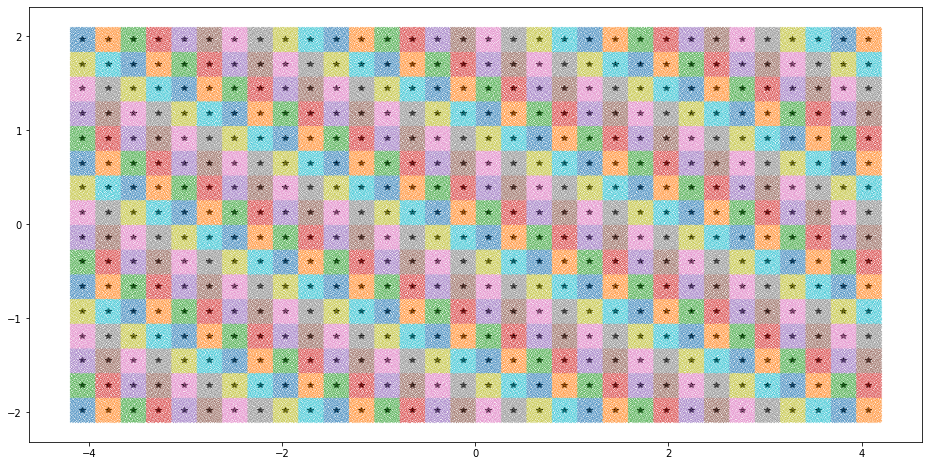

In [80]:
pos = np.zeros((nblock, 2, blockSize), dtype = fp)

block_center = np.zeros((nblock,2))
block_center[:,0] = np.tile((np.arange(grid_w)-grid_w/2 + 1/2)*per_dis, grid_h)
block_center[:,1] = np.repeat((np.arange(grid_h)-grid_h/2 + 1/2)*per_dis, grid_w)

fig = plt.figure(figsize = [16, 8])
ax = fig.add_subplot(111)
ax.plot(block_center[:,0], block_center[:,1], '*k')

for i in range(nblock):
    pos[i,:,:] = square_pos(np.array([per_dis, per_dis]), blockSize, block_center[i,:])
    ax.plot(pos[i,0,:], pos[i,1,:], '.', ms = 0.25)

#for i in range(nblock):
#    get_block_pos

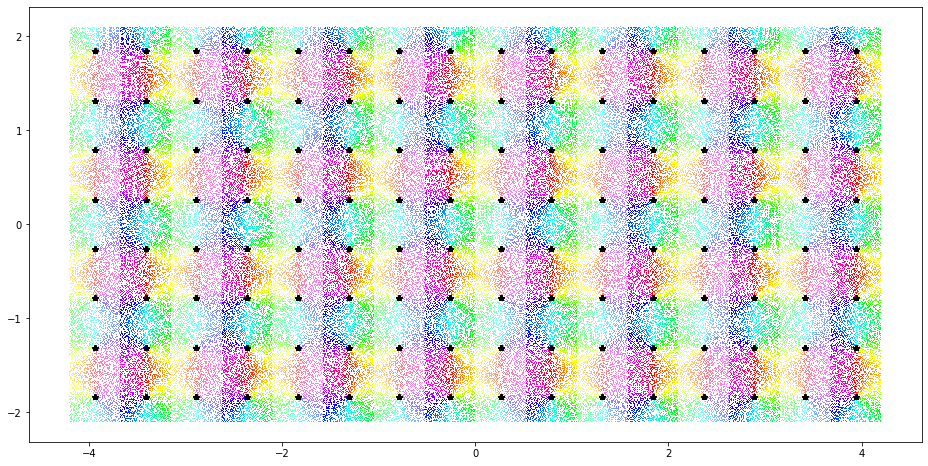

In [81]:
# features: OP, OD
OD_center = (np.arange(nOD)-nOD/2+1/2)*d
phase = np.pi/4
OP = np.zeros((nblock,blockSize), dtype = 'f4')
OD = np.zeros((nblock,blockSize), dtype = 'f4')
fig = plt.figure(figsize = [16, 8])
ax = fig.add_subplot(111)
marker = 's'
for i in range(nOD):
    OP_center = np.zeros((2,nOP))
    OP_center[0,:] = OD_center[i]
    OP_center[1,:] = (np.arange(nOP)-nOP/2+1/2)*d
    LR = np.mod(i, 2)
    sat0 = (LR + 1)/2
    val0 = 1.0
    for j in range(nOP):
        center = OP_center[:,j]
        phase0 = np.mod(j,2)*np.pi/2
        for k in range(nblock):
            if np.linalg.norm(block_center[k,:]-center) < block_r+r*np.sqrt(2):
                OP_set, pick = square_OP(center, r, phase+phase0, pos[k,:,:], np.mod(i+j,2)) #np.mod(i + j,2)
                OP[k, pick] = OP_set[pick]
                OD[k, pick] = LR
                npick = np.sum(pick)
                hsv = np.zeros((npick,3))
                hsv[:,1] = sat0
                hsv[:,2] = val0
                hue = (OP[k,pick] + np.pi/2)/np.pi
                hsv[:,0] = hue
                ax.scatter(pos[k,0,pick], pos[k,1,pick], s = 0.25, marker = marker, color = clr.hsv_to_rgb(hsv), edgecolors = 'none')
                ax.plot(center[0],center[1],'*k')

In [9]:
pos_filename = 'V1_allpos-'+theme+'.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize, dim]).astype('u4').tofile(f)
    pos.tofile(f)

In [101]:
ratio = 8/np.pi # from half a circle to square
# Malpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798) # cells/deg^2
parvo_slice = lambda E: np.pi*E*parvo_den_alt(E)
r = integrate.quad(parvo_slice, 0, ecc)
nparvo = round(r[0]*ratio)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012) # cells/deg^2
magno_slice = lambda E: np.pi*E*magno_den_alt(E)
r = integrate.quad(magno_slice, 0, ecc)
nmagno = round(r[0]*ratio)
print(f'{nparvo} parvo cells, {nmagno} cells')

LGN_vpos = np.zeros((2,nmagno+nparvo), dtype = 'f4')


29678 parvo cells, 322 cells


In [9]:
prec = 'f4'
LGN_vpos_file = 'LGN_vpos-'+theme+'.bin'
with open(LGN_vpos_file, 'wb') as f:
    # parvo first
    np.array([nparvo+nmagno], dtype = 'u4').tofile(f)
    np.array([0], dtype = 'u4').tofile(f)
    np.array([ecc], dtype = prec).tofile(f)
    # cart
    np.array([-ecc, 2*ecc, -ecc, 2*ecc], dtype = prec).tofile(f)
    merged = np.hstack((parvo_pos_I5_cart, parvo_pos_C6_cart))
    assert(merged.shape[0] == 2)
    assert(merged.shape[1] == nparvo_I5 + nparvo_C6)
    merged.astype(prec).tofile(f)
    # type
    np.hstack((RG_OnOff_I5, RG_OnOff_C6)).astype('u4').tofile(f)
    # polar
    merged = np.hstack((parvo_pos_I5, parvo_pos_C6))
    assert(merged.shape[0] == 2)
    assert(merged.shape[1] == nparvo_I5 + nparvo_C6)
    merged.astype(prec).tofile(f)

NameError: name 'square_pos' is not defined